In [1]:
import matplotlib
import numpy as np
import pickle
import tqdm
from astropy.table import Table
from matplotlib import (cm, pyplot as plt)

from emulator import BNSWaveformEmulator
from utils import strain_fitting_function_corrected

%matplotlib inline

In [2]:
# Load the data.
with open("input_variables.pkl", "rb") as fp:
    data = pickle.load(fp)

waveform_parameters, label_names, waveform_names, amplitudes, \
    maximum_amplitude, waveform_ivar, scaled_asd, bns_maxima, _, __, ___, \
    psd, frequencies = data
    
with open("pl_params.pkl", "rb") as fp:
    eos_descr, eos_parameters, eos_coeff = pickle.load(fp)

waveform_parameters = Table.from_pandas(waveform_parameters)

# NEED UNSCALED MASSES ARGH
waveform_parameters["M1"] = 1.375 * waveform_parameters["M1"]

# Need unscaled f2 values. Load from text.
t2 = Table.read("10.1103_t2.txt", format="ascii")
waveform_parameters["f2"] = 1000 * np.array(
    [t2["f_2"][t2["model"] == wn][0] for wn in waveform_names])


# Even though we may not use them, calculate the tidal Love number 
# for equal mass binaries (eq 14 of 1604.00246)
waveform_parameters["lambda"] = (2.0/3.0) * waveform_parameters["Meank2"] \
                              * waveform_parameters["MeanR"]**5

# Calculate dimensionless tidal deformability (p12 of 1604.00246).
waveform_parameters["Lambda"] = (waveform_parameters["lambda"]/waveform_parameters["M1"]**5)**(1.0/5)

# 1/Lambda is something that scales as kappa, so it may be more useful than Lambda
waveform_parameters["1/Lambda"] = 1.0/waveform_parameters["Lambda"]


In [3]:
# Build a hierarchical model using 1/Lambda as the parameter that describes the equation of state.

model_kwds = dict(eos_parameter_name="Kappa_calc")
# ARC to PE: What should we be doing here?
supply_s2_for_ff = True

model = BNSWaveformEmulator(**model_kwds)

/home/acas0005/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


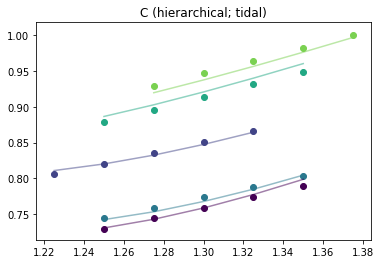

In [4]:
# Fit the hierarchical parameters by power laws
p_opt, data_dict = model._hierarchically_fit_waveform_parameters(waveform_parameters)
# Make some 
eos_descriptions = [ea.split("-")[0] for ea in waveform_names]
unique_eos_descriptions = list(set([ea for ea in eos_descriptions]))
waveform_eos_idx = np.array(
    [unique_eos_descriptions.index(ea) for ea in eos_descriptions])


x, y = (data_dict["M1"], data_dict["y"])

N, D = data_dict["y"].shape
E = len(unique_eos_descriptions)
design_matrix = np.vstack([waveform_parameters[model.eos_parameter_name], np.ones(N)])
alpha = (p_opt["a"].T @ design_matrix).T
beta = (p_opt["b"].T @ design_matrix).T

cmap = cm.viridis

for j, parameter_name in enumerate(model.hierarchical_parameter_names):

    fig, ax = plt.subplots()

    for unique_eos_idx in list(set(waveform_eos_idx)):

        color = cmap(float(unique_eos_idx)/E)

        match = waveform_eos_idx == unique_eos_idx

        yi = alpha[match, j] * x[match]**beta[match, j]

        ax.plot(x[match], yi, c=color, alpha=0.5)
        ax.scatter(x[match], y[match, j], c=color, vmin=0, vmax=E)

    ax.set_title("{} (hierarchical; tidal)".format(parameter_name))


In [5]:
# OK now fit the waveforms.
# Here we align the waveforms by the maximum power in the amplitude spectrum.
model.fit(waveform_parameters, frequencies, amplitudes)

/home/acas0005/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [6]:
# Make some predictions.
predictions = model.predict(waveform_parameters["M1"], waveform_parameters[model.eos_parameter_name])

N, F = amplitudes.shape
one_to_one_fitting_factors = np.zeros(N)
for i in tqdm.tqdm(range(N)):
    
    # ARC to PE: Shouldn't we be giving model._p_opt_waveform["sigma"]**2 (as s2) instead of 0 here?
    one_to_one_fitting_factors[i] = strain_fitting_function_corrected(
        amplitudes[i], predictions[i],
        frequencies, psd,
        model._p_opt_waveform["sigma"]**2 if supply_s2_for_ff else 0)
    

100%|██████████| 25/25 [00:00<00:00, 3491.06it/s]


Text(0.5,0,'Fitting factors (one-to-one)')

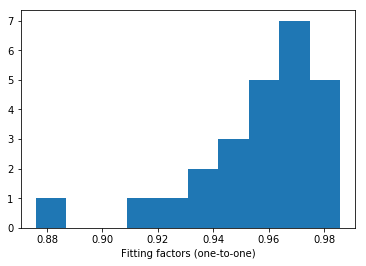

In [7]:
fig, ax = plt.subplots()
ax.hist(one_to_one_fitting_factors)
ax.set_xlabel("Fitting factors (one-to-one)")

In [8]:
# Perform LOOCV.
loocv_fitting_factors = np.zeros(N)
loocv_predictions = np.zeros((N, F))
for i in tqdm.tqdm(range(N)):
    
    mask = np.ones(N, dtype=bool)
    mask[i] = False
    
    loocv_model = BNSWaveformEmulator(**model_kwds)
    loocv_model.fit(waveform_parameters[mask], frequencies, amplitudes[mask])
    
    # Just assume that we had perfect frequencies since we can marginalise it out later.
    frequency_shift = frequencies[np.argmax(amplitudes[i])] - loocv_model._p_opt_f2[0]
    
    prediction = loocv_model.predict(waveform_parameters["M1"][i],
                                     waveform_parameters[model.eos_parameter_name][i],
                                     frequency_shifts=[frequency_shift])
    
    # ARC to PE: Should we be giving s^2 instead of 0?
    loocv_fitting_factors[i] = strain_fitting_function_corrected(
        amplitudes[i], prediction, frequencies, psd,
        loocv_model._p_opt_waveform["sigma"]**2 if supply_s2_for_ff else 0)
    
    loocv_predictions[i] = prediction
    

  0%|          | 0/25 [00:00<?, ?it/s]/home/acas0005/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


Text(0.5,0,'Fitting factors (LOOCV)')

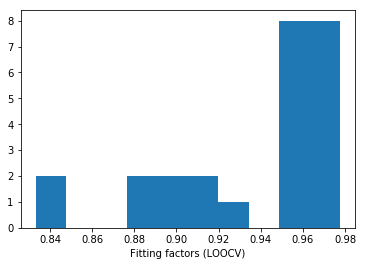

In [9]:
fig, ax = plt.subplots()
ax.hist(loocv_fitting_factors)
ax.set_xlabel("Fitting factors (LOOCV)")

In [10]:
# Perform LOOCV and fit for the parameters at test time 
loocv_test_fitting_factors = np.zeros(N)
loocv_waveform_parameters = np.zeros((N, 3), dtype=float)
loocv_test_predictions = np.zeros((N, F))
for i in tqdm.tqdm(range(N)):
    
    mask = np.ones(N, dtype=bool)
    mask[i] = False
    
    loocv_model = BNSWaveformEmulator(**model_kwds)
    loocv_model.fit(waveform_parameters[mask], frequencies, amplitudes[mask])
    
    initial = [
        waveform_parameters["M1"][i], 
        waveform_parameters[loocv_model.eos_parameter_name][i],
        frequencies[np.argmax(amplitudes[i])] - loocv_model._p_opt_f2[0]
    ]
    
    p_opt_M1, p_opt_eos_parameter, p_opt_frequency_shift = loocv_model.test(amplitudes[i],
                                                                            psd,
                                                                            supply_s2_for_ff=supply_s2_for_ff,
                                                                            initial=initial)
    
    prediction = loocv_model.predict(p_opt_M1,
                                     p_opt_eos_parameter,
                                     frequency_shifts=[p_opt_frequency_shift - model._p_opt_f2[0]])
    
    loocv_test_predictions[i] = prediction
    loocv_waveform_parameters[i] = [p_opt_M1, p_opt_eos_parameter, p_opt_frequency_shift]
    loocv_test_fitting_factors[i] = strain_fitting_function_corrected(
        amplitudes[i], loocv_test_predictions[i], frequencies, psd,
        loocv_model._p_opt_waveform["sigma"]**2 if supply_s2_for_ff else 0)
    
    #print(f"LOOCV: {i} {loocv_test_fitting_factors[i]}")



  0%|          | 0/25 [00:00<?, ?it/s]/home/acas0005/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
100%|██████████| 25/25 [00:25<00:00,  1.02s/it]


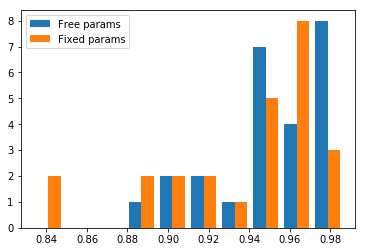

In [11]:
fig, ax = plt.subplots()
ax.hist([loocv_test_fitting_factors, loocv_fitting_factors],
        label=("Free params", "Fixed params"))
plt.legend()

In [12]:
print(np.median(loocv_test_fitting_factors), np.median(loocv_fitting_factors))

0.9539102979876312 0.9529236822968318


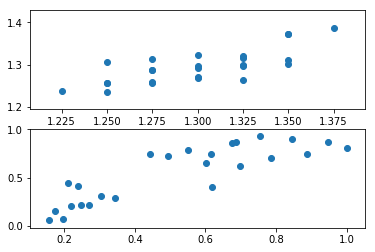

In [13]:
fig, axes = plt.subplots(2)
axes[0].scatter(waveform_parameters["M1"], loocv_waveform_parameters.T[0])
axes[1].scatter(waveform_parameters[loocv_model.eos_parameter_name], loocv_waveform_parameters.T[1])
